# Classificação com Embeddings (Gemini ou Sentence-Transformers)

**Objetivo:** Comparar classificadores clássicos sobre os embeddings gerados (via Gemini API ou sentence-transformers local) e avaliar o desempenho.

**Nota:** Este notebook funciona com embeddings gerados tanto pelo Google Gemini API quanto pelo sentence-transformers (alternativa local).


In [2]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Carregar embeddings


In [3]:
# Carregar embeddings
# Nota: O arquivo pode conter embeddings do Gemini API ou sentence-transformers
with open('../data/processed/embeddings_gemini.pkl', 'rb') as f:
    data = pickle.load(f)

X_emb = data['X_emb']
y = data['y']
target_names = data['target_names']
model_name = data.get('model_name', 'unknown')

print(f"Shape dos dados: {X_emb.shape}")
print(f"Modelo usado para gerar embeddings: {model_name}")
print(f"Classes: {target_names}")
print(f"Distribuição: {pd.Series(y).value_counts().sort_index().to_dict()}")
print(f"\nDimensão do embedding: {X_emb.shape[1]}")

Shape dos dados: (5611, 384)
Modelo usado para gerar embeddings: sentence-transformers/all-MiniLM-L6-v2
Classes: ['rec.autos', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.space', 'talk.politics.guns', 'talk.politics.mideast']
Distribuição: {0: 931, 1: 951, 2: 973, 3: 954, 4: 885, 5: 917}

Dimensão do embedding: 384


## 2. Divisão Treino/Teste (80/20)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_emb, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Treino: {X_train.shape[0]} documentos")
print(f"Teste: {X_test.shape[0]} documentos")


Treino: 4488 documentos
Teste: 1123 documentos


## 3. Definir e treinar modelos


In [5]:
# Definir modelos
# Nota: MultinomialNB requer dados não-negativos, então usamos GaussianNB
models = {
    'GaussianNB': GaussianNB(),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'DecisionTree': DecisionTreeClassifier(random_state=42, max_depth=20),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000)
}

# Treinar e avaliar cada modelo
results = {}
predictions = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Treinando {name}...")
    print(f"{'='*60}")
    
    # Treinar
    model.fit(X_train, y_train)
    
    # Prever
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    results[name] = {
        'accuracy': accuracy,
        'f1_macro': f1_macro
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1: {f1_macro:.4f}")

# Criar DataFrame com resultados
df_results = pd.DataFrame(results).T
print(f"\n{'='*60}")
print("Resumo dos Resultados")
print(f"{'='*60}")
print(df_results)



Treinando GaussianNB...
Accuracy: 0.8557
Macro F1: 0.8563

Treinando KNN (k=5)...
Accuracy: 0.8914
Macro F1: 0.8916

Treinando DecisionTree...
Accuracy: 0.6109
Macro F1: 0.6103

Treinando LogisticRegression...
Accuracy: 0.8789
Macro F1: 0.8787

Resumo dos Resultados
                    accuracy  f1_macro
GaussianNB          0.855744  0.856265
KNN (k=5)           0.891362  0.891615
DecisionTree        0.610864  0.610286
LogisticRegression  0.878896  0.878663


## 4. Validação Cruzada (k=5)


In [6]:
# Validação cruzada para cada modelo
cv_results = {}

for name, model in models.items():
    print(f"\nExecutando validação cruzada para {name}...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    cv_results[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    print(f"F1 Macro (CV): {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Criar DataFrame
df_cv = pd.DataFrame({
    name: [cv_results[name]['mean'], cv_results[name]['std']]
    for name in cv_results.keys()
}, index=['Mean', 'Std']).T

print(f"\n{'='*60}")
print("Resultados da Validação Cruzada (F1 Macro)")
print(f"{'='*60}")
print(df_cv)



Executando validação cruzada para GaussianNB...
F1 Macro (CV): 0.8627 (+/- 0.0200)

Executando validação cruzada para KNN (k=5)...
F1 Macro (CV): 0.8909 (+/- 0.0174)

Executando validação cruzada para DecisionTree...
F1 Macro (CV): 0.6124 (+/- 0.0235)

Executando validação cruzada para LogisticRegression...
F1 Macro (CV): 0.8803 (+/- 0.0252)

Resultados da Validação Cruzada (F1 Macro)
                        Mean       Std
GaussianNB          0.862727  0.009977
KNN (k=5)           0.890897  0.008684
DecisionTree        0.612388  0.011759
LogisticRegression  0.880258  0.012625


## 5. Matrizes de Confusão


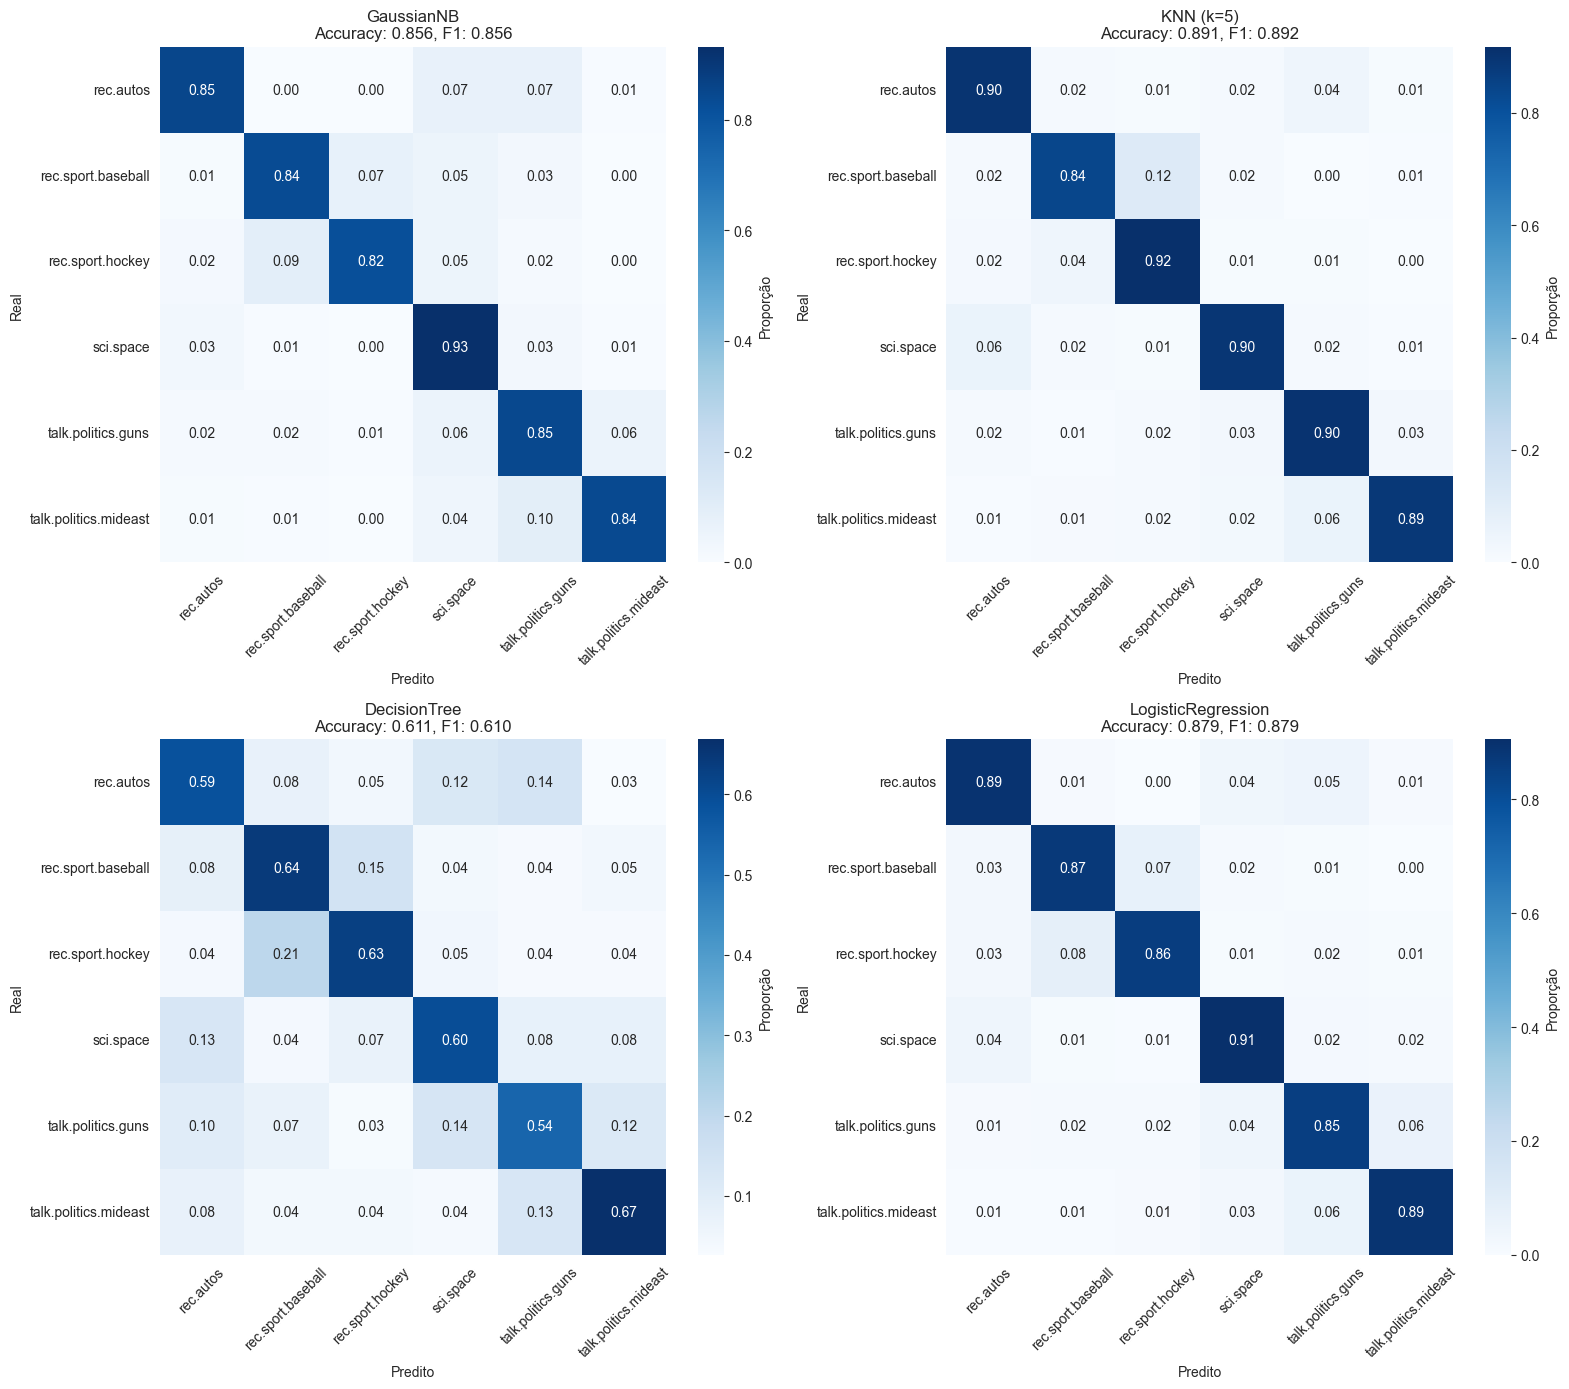

In [7]:
# Criar diretório para figuras
os.makedirs('../reports/figures', exist_ok=True)
os.makedirs('../reports/metrics', exist_ok=True)

# Plotar matrizes de confusão
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names,
                ax=axes[idx], cbar_kws={'label': 'Proporção'})
    axes[idx].set_title(f'{name}\nAccuracy: {results[name]["accuracy"]:.3f}, F1: {results[name]["f1_macro"]:.3f}')
    axes[idx].set_xlabel('Predito')
    axes[idx].set_ylabel('Real')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig('../reports/figures/confusion_matrices_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()


## 6. Salvar métricas e resultados


In [8]:
# Salvar resultados em CSV
df_results.to_csv('../reports/metrics/classification_embeddings_results.csv')
df_cv.to_csv('../reports/metrics/classification_embeddings_cv.csv')

print("Resultados salvos em:")
print("  - ../reports/metrics/classification_embeddings_results.csv")
print("  - ../reports/metrics/classification_embeddings_cv.csv")

# Gerar relatórios detalhados por modelo
for name, y_pred in predictions.items():
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(f'../reports/metrics/classification_embeddings_{name.lower().replace(" ", "_")}_report.csv')
    print(f"  - ../reports/metrics/classification_embeddings_{name.lower().replace(' ', '_')}_report.csv")


Resultados salvos em:
  - ../reports/metrics/classification_embeddings_results.csv
  - ../reports/metrics/classification_embeddings_cv.csv
  - ../reports/metrics/classification_embeddings_gaussiannb_report.csv
  - ../reports/metrics/classification_embeddings_knn_(k=5)_report.csv
  - ../reports/metrics/classification_embeddings_decisiontree_report.csv
  - ../reports/metrics/classification_embeddings_logisticregression_report.csv
